### Test the trained model on data distribution

In [1]:
import random
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import torch
import learn2learn as l2l
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
# The corase reconstruction is the rss of the zerofilled multi-coil kspaces
# after inverse FT.
from functions.data.transforms import UnetDataTransform_norm, normalize
# Import a torch.utils.data.Dataset class that takes a list of data examples, a path to those examples
# a data transform and outputs a torch dataset.
from functions.data.mri_dataset import SliceDataset
# Unet architecture as nn.Module
from functions.models.unet import Unet
# Function that returns a MaskFunc object either for generatig random or equispaced masks
from functions.data.subsample import create_mask_for_mask_type
# Implementation of SSIMLoss
from functions.training.losses import SSIMLoss

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Set seed
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
def evaluate(model, dataloader):
    model.eval()
    total_l1_loss = 0.0
    total_ssim_loss = 0.0
    total_psnr_loss = 0.0
    total_nmse_loss = 0.0
    l1_loss = torch.nn.L1Loss(reduction='sum')
    ssim_fct = SSIMLoss()
    psner_mse_fct = torch.nn.MSELoss(reduction='mean')
    mse_fct = torch.nn.MSELoss(reduction='sum')

    for iter, batch in enumerate(dataloader): 
        input_image, target_image, mean, std, fname, slice_num = batch
        val_inputs = input_image.to(device)
        val_targets = target_image.to(device)
        std = std.to(device)
        mean = mean.to(device)

        val_outputs = model(val_inputs)
        val_outputs = val_outputs * std + mean

        # NMAE
        l1 = l1_loss(val_outputs, val_targets) / torch.sum(torch.abs(val_targets))
        total_l1_loss += l1.item()
        # NMSE 
        nmse_loss = mse_fct(val_outputs, val_targets) / torch.sum(torch.abs(val_targets)**2)
        total_nmse_loss += nmse_loss.item()
        # PSNR
        psnr_loss = 20*torch.log10(torch.tensor(val_targets.max().unsqueeze(0).item()))-10*torch.log10(psner_mse_fct(val_outputs,val_targets))
        total_psnr_loss += psnr_loss.item()
        # SSIM = 1 - loss
        ssim_loss = ssim_fct(val_outputs, val_targets, data_range = val_targets.max().unsqueeze(0))
        total_ssim_loss += (1-ssim_loss.item())

    validation_loss_l1 = total_l1_loss / len(dataloader) 
    validation_loss_NMSE = total_nmse_loss / len(dataloader)
    validation_loss_PSNR = total_psnr_loss / len(dataloader)
    validation_loss_SSIM = total_ssim_loss / len(dataloader)

    return validation_loss_l1, validation_loss_NMSE, validation_loss_PSNR, validation_loss_SSIM

### Testing Metrics

Load model

In [3]:
checkpoint_path = '/cheng/metaMRI/metaMRI/save/E6.3_maml(NMSE)_T8x200_1inner_200epoch/E6.3_maml(NMSE)_T8x200_1inner_200epoch_E178_best.pth'


# '/cheng/metaMRI/metaMRI/save/E6.2_standard_NMAE_Q1/E6.2_standard_NMAE_Q1_E49_best.pth'
# '/cheng/metaMRI/metaMRI/save/E6.2_standard_NMAE_Q2/E6.2_standard_NMAE_Q2_E59_best.pth'
# '/cheng/metaMRI/metaMRI/save/E6.2_standard_NMAE_Q3/E6.2_standard_NMAE_Q3_E70_best.pth'

# '/cheng/metaMRI/metaMRI/save/E6.2_maml(NMAE)_T2x300_200epoch/E6.2_maml(NMAE)_T2x300_200epoch_E178_best.pth'

# '/cheng/metaMRI/metaMRI/save/E6.2_standard_NMAE_(P1+P2)/E6.2_standard_NMAE_(P1+P2)_E57_best.pth'
# '/cheng/metaMRI/metaMRI/save/E6.2_standard_NMAE_P1/E6.2_standard_NMAE_P1_E46_best.pth'
# '/cheng/metaMRI/metaMRI/save/E6.2_standard_NMAE_P2/E6.2_standard_NMAE_P2_E50_best.pth'

model = Unet(in_chans=1, out_chans=1, chans=32, num_pool_layers=4, drop_prob=0.0)
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device).eval()

Load data

In [8]:
path_test = '/cheng/metaMRI/metaMRI/data_dict/E6.2/brain_test_AXT2_Aera_5-8.yaml'
# '/cheng/metaMRI/metaMRI/data_dict/E6.1/knee_test_PD_Skyra_15-22.yaml'
# '/cheng/metaMRI/metaMRI/data_dict/E6.1/knee_test_PDFS_Aera_15-22.yaml'
# '/cheng/metaMRI/metaMRI/data_dict/E6.2/brain_test_AXT1POST_TrioTim_5-8.yaml'
# '/cheng/metaMRI/metaMRI/data_dict/E6.2/brain_test_AXFLAIR_Skyra_5-8.yaml'
# '/cheng/metaMRI/metaMRI/data_dict/E6.2/brain_test_AXT2_Aera_5-8.yaml'

# mask function and data transform
mask_function = create_mask_for_mask_type(mask_type_str = 'random', self_sup = False, 
                    center_fraction = 0.08, acceleration = 4.0, acceleration_total = 3.0)
data_transform_test = UnetDataTransform_norm('multicoil', mask_func = mask_function, use_seed=True, mode='adapt')
# dataset: num_sample_subset x 3
testset = SliceDataset(dataset = path_test, path_to_dataset='', path_to_sensmaps=None, provide_senmaps=False, 
                      challenge="multicoil", transform=data_transform_test, use_dataset_cache=True)
test_dataloader = torch.utils.data.DataLoader(dataset = testset, batch_size = 1, shuffle = False, 
                                generator = torch.Generator().manual_seed(1), pin_memory = True)


Evaluate

In [9]:
test_L1, test_NMSE, test_PSNR, test_SSIM = evaluate(model, test_dataloader)
print('Testing L1: ', test_L1)
print('Testing NMSE: ', test_NMSE)
print('Testing PSNR: ', test_PSNR)
print('Testing SSIM: ', test_SSIM) 

Testing L1:  0.13800676529606185
Testing NMSE:  0.022651509867670637
Testing PSNR:  30.417801297505697
Testing SSIM:  0.8601830820242564


### Inference

Renew the data

In [44]:
iterator = iter(test_dataloader)

In [49]:
batch = next(iterator)
input_image, target_image, mean, std, fname, slice_num = batch
print(fname)
print(slice_num)
input_image = input_image.to(device)
target_image = target_image.to(device)
std = std.to(device)
mean = mean.to(device)

output = model(input_image)
output = output * std + mean

# SSIM
ssim_fct = SSIMLoss()
ssim = 1 - ssim_fct(output, target_image, data_range = target_image.max().unsqueeze(0)).item()
ssim

['file_brain_AXT1_202_2020017']
tensor([6])


0.8733124136924744

Plot

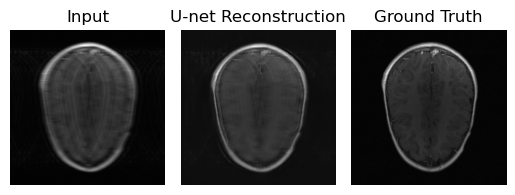

In [50]:
fig, axes = plt.subplots(1, 3)

axes[0].imshow(input_image.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
axes[0].set_title('Input')
axes[0].axis('off')

axes[1].imshow(output.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
axes[1].set_title('U-net Reconstruction')
axes[1].axis('off')

axes[2].imshow(target_image.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
axes[2].set_title('Ground Truth')
axes[2].axis('off')

plt.subplots_adjust(wspace=0.1)
plt.show()